In [1]:
import sys
sys.path.append('/opt/conda/pkgs')
sys.path.append("/home/miaocj/docker_dir/kNN-overlap-finder/.snakemake/conda/4262b1bf4bf1ffb403c0eb7a42ad5906_/lib/python3.12/site-packages")
sys.path.append("/home/miaocj/docker_dir/kNN-overlap-finder/.snakemake/conda/4506eccf78279d93d0e8a34c035e91c5_/lib/python3.12/site-packages")
sys.path.append("/home/miaocj/docker_dir/kNN-overlap-finder/.snakemake/conda/6bda807e3967eae797c7b1b9eeaee8db_/lib/python3.12/site-packages")
sys.path.append("/home/miaocj/docker_dir/kNN-overlap-finder/.snakemake/conda/c2a47d89d1d34e789fdf782557bb7194_/lib/python3.12/site-packages")
sys.path.append("/home/miaocj/docker_dir/kNN-overlap-finder/.snakemake/conda/c6c5514ada15b890fb27d1e36371554c_/lib/python3.12/site-packages")
sys.path.append("/home/miaocj/docker_dir/kNN-overlap-finder/.snakemake/conda/d964a294c2d0fef56a434c021026281e_/lib/python3.12/site-packages")
sys.path.append("/home/miaocj/docker_dir/kNN-overlap-finder/.snakemake/conda/e1c932db5cd4271709e54d8028824bc9_/lib/python3.12/site-packages")

import pickle, os, gzip, json, sys, itertools
from pathlib import Path
from importlib import reload
from dataclasses import dataclass, field
import collections
import matplotlib.pyplot as plt
import networkx as nx
import numpy as np
import pandas as pd
import pysam
import scipy as sp
import seaborn
import sharedmem


plt.rcParams["figure.facecolor"] = "white"
plt.rcParams["figure.dpi"] = 300


sys.path.append("scripts")
sys.path.append("../../scripts")

In [2]:
from graph import OverlapGraph, GenomicInterval, get_overlap_statistics, remove_false_edges
from plots import plot_read_graph, mp_plot_read_graphs, get_graphviz_layout, get_umap_layout

/home/miaocj/docker_dir/kNN-overlap-finder/scripts/../lib


In [39]:
import glob
evaluate_dir = '/home/miaocj/docker_dir/kNN-overlap-finder/data/evaluation/human/IGK/ONT_R9/kmer_k16/'
file_list = glob.glob(evaluate_dir + '*overlap_stat.tsv')  
  
# 循环打开文件  
statistic_dfs =[]
for file in file_list:  
    df = pd.read_csv(file, sep='\t') 
    statistic_dfs.append(df)

all_stat_df = pd.concat(statistic_dfs,ignore_index = True)
all_stat_df['connected_fraction'] = 1 - all_stat_df['singleton_fraction']
##筛选用于绘图的method
methods = all_stat_df['description'].unique()
visul_method = []
for method in methods:
    if 'Sim' in method:
        visul_method.append(method)

method_compare = all_stat_df[all_stat_df['description'].isin(visul_method)] 
df = method_compare

visul_method

['SimHash_IDF',
 'SimHash_TF',
 'SimHash_TF-IDF',
 'SimHash_None',
 'SimHash_TF-64bit-re200']

In [34]:
df

,Unnamed: 0,description,n_neighbors,precision,nr_precision,recall,nr_recall,singleton_count,singleton_fraction,N50,N50_percentage,elapsed_time:tfidf,elapsed_time:dimension_reduction,elapsed_time:nearest_neighbors,connected_fraction,repeat_time
76,0,SimHash_TF-64bit,2,0.667962,0.201286,0.033341,0.166408,3109,0.335022,25,0.27%,NaN,NaN,NaN,0.664978,20.0
77,1,SimHash_TF-64bit,3,0.654349,0.178219,0.048072,0.216857,2198,0.236853,101,1.09%,NaN,NaN,NaN,0.763147,20.0
78,2,SimHash_TF-64bit,4,0.643472,0.161835,0.062268,0.259386,1652,0.178017,181,1.95%,NaN,NaN,NaN,0.821983,20.0
79,3,SimHash_TF-64bit,5,0.634736,0.148100,0.075990,0.293665,1314,0.141595,215,2.32%,NaN,NaN,NaN,0.858405,20.0
80,4,SimHash_TF-64bit,6,0.628187,0.138380,0.089534,0.326670,1057,0.113901,229,2.47%,NaN,NaN,NaN,0.886099,20.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
394,14,SimHash_TF-64bit,16,0.595215,0.093274,0.216856,0.562853,282,0.030388,539,5.81%,NaN,NaN,NaN,0.969612,100.0
395,15,SimHash_TF-64bit,17,0.591885,0.090360,0.228445,0.577639,265,0.028556,551,5.94%,NaN,NaN,NaN,0.971444,100.0
396,16,SimHash_TF-64bit,18,0.588653,0.087713,0.239776,0.591760,246,0.026509,551,5.94%,NaN,NaN,NaN,0.973491,100.0
397,17,SimHash_TF-64bit,19,0.585823,0.085347,0.251067,0.605826,232,0.025000,582,6.27%,NaN,NaN,NaN,0.975000,100.0


In [44]:
df = all_stat_df

In [ ]:
simhash = pd.read_csv('/home/miaocj/docker_dir/test_simhash.csv', sep='\t')
sim_df = simhash.iloc[1368:,:]
sim_df['connected_fraction'] = 1 - sim_df['singleton_fraction']
sim = sim_df[sim_df.repeat_time ==100] 
all_df = pd.concat([all_stat_df.iloc[:,1:],sim])

In [15]:
all_stat_df = all_stat_df.replace({'MinHash_Jaccard_None_None':'MinHash'})  
all_stat_df.replace({'MinHash_Jaccard_None_None':'MinHash'})  
visul_method = ['Minimap2','SimHash_None','MinHash']
df_HLA= all_stat_df[all_stat_df['description'].isin(visul_method)] 
df = method_compare


In [17]:
df = pd.concat([df_HLA,df_IGH,df_IGK])

,Unnamed: 0,description,n_neighbors,precision,nr_precision,recall,nr_recall,singleton_count,singleton_fraction,N50,N50_percentage,elapsed_time:tfidf,elapsed_time:dimension_reduction,elapsed_time:nearest_neighbors,connected_fraction,repeat_time
19,0,Minimap2,2,0.967506,0.127622,0.073458,0.124466,438,0.033885,1769,13.69%,NaN,NaN,7.578197,0.966115,NaN
20,1,Minimap2,3,0.969211,0.127435,0.108786,0.183732,298,0.023054,6372,49.30%,NaN,NaN,7.578197,0.976946,NaN
21,2,Minimap2,4,0.969271,0.124713,0.142814,0.236034,236,0.018258,6388,49.42%,NaN,NaN,7.578197,0.981742,NaN
22,3,Minimap2,5,0.968427,0.123782,0.176004,0.288970,198,0.015318,6405,49.55%,NaN,NaN,7.578197,0.984682,NaN
23,4,Minimap2,6,0.967126,0.123175,0.208314,0.340798,170,0.013152,6411,49.60%,NaN,NaN,7.578197,0.986848,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
337,14,MinHash,16,0.606977,0.067276,0.202500,0.371747,317,0.034159,1048,11.29%,NaN,NaN,259.072199,0.965841,NaN
338,15,MinHash,17,0.604849,0.066021,0.213620,0.386200,287,0.030927,1051,11.33%,NaN,NaN,259.072199,0.969073,NaN
339,16,MinHash,18,0.602997,0.065173,0.224830,0.402481,263,0.028341,1130,12.18%,NaN,NaN,259.072199,0.971659,NaN
340,17,MinHash,19,0.601251,0.064271,0.235927,0.417710,249,0.026832,1130,12.18%,NaN,NaN,259.072199,0.973168,NaN


In [ ]:
visul_method = ['scBimap', 'TruncatedSVD', 'spectrual', 'PCA','isomap']
method_compare = all_stat_df[all_stat_df['description'].isin(visul_method)] 
df = method_compare


In [ ]:

visul_method = ['Minimap2',
       'HNSW_Cosine_scBiMap_500d_TF-IDF','Exact_Cosine_None_TF-IDF', 'MinHash_Jaccard_None_None']
method_compare = all_stat_df[all_stat_df['description'].isin(visul_method)] 
df = method_compare

In [ ]:
methods

In [ ]:
methods
visul_method = ['Minimap2 all-vs-all',
                'WeightedMinHash,Jaccard,None,TF-IDF',
       'HNSW,Euclidean,scBiMapEmbedding,500,TF-IDF',
       'ExactNearestNeighbors,Cosine,scBiMapEmbedding,500,TF-IDF', 
       'MinHash,Jaccard,None,TF-IDF',
       'ProductQuantization,Cosine,scBiMapEmbedding,500,TF-IDF','SimHash','Blend','Exact_Cosine_None_None']
method_compare = all_df[all_df['description'].isin(visul_method)] 
df = method_compare


In [ ]:
for method in methods:
    if 'Exact' in method:
        print(method)

In [ ]:
k_values = np.arange(2, 21)
y_labels = dict(
    precision="Precision",
    nr_recall="Recall\n(non-redundant overlaps)",
    N50="Graph N50\n(after removing incorrect edges)",
    connected_fraction="Connected fraction\n(after removing incorrect edges)"
)

if len(visul_method) <= 10:
    color_list = seaborn.color_palette("tab10")
elif len(visul_method) <= 20:
    color_list = seaborn.color_palette("tab20")
else:
    color_list = seaborn.color_palette("rainbow")

fig, axes = plt.subplots(2, 2, figsize=(12, 6), constrained_layout=True)
for i, ax in enumerate( itertools.chain(*axes) ):
    y = list(y_labels)[i]
    x = 'n_neighbors'
    hue = 'description'
    for j,(desc, group) in enumerate(df.groupby(hue)): 
        if 'Sim' in desc:  
            linestyle = 'solid'  
        elif 'Minimap2' in desc: 
            linestyle = 'dotted'
        elif 'MinHash' in desc:
            linestyle = 'dashdot'
        else:
            linestyle = 'dashed'
        ax.plot(group[x], group[y], label=desc, color = 'black', linestyle = linestyle)
    ax.set_xticks([ x for x in k_values if x%2==0]) 
    ax.set_xlabel("Number of neighbors")  
    ax.set_ylabel(y_labels[y])  
    ax.grid(axis='both', color='k', alpha=0.1)  
    
    if i == 1:
        ax.legend(loc="upper left", bbox_to_anchor=(1.02, 1))

    ax.spines[['top', 'right']].set_visible(False)

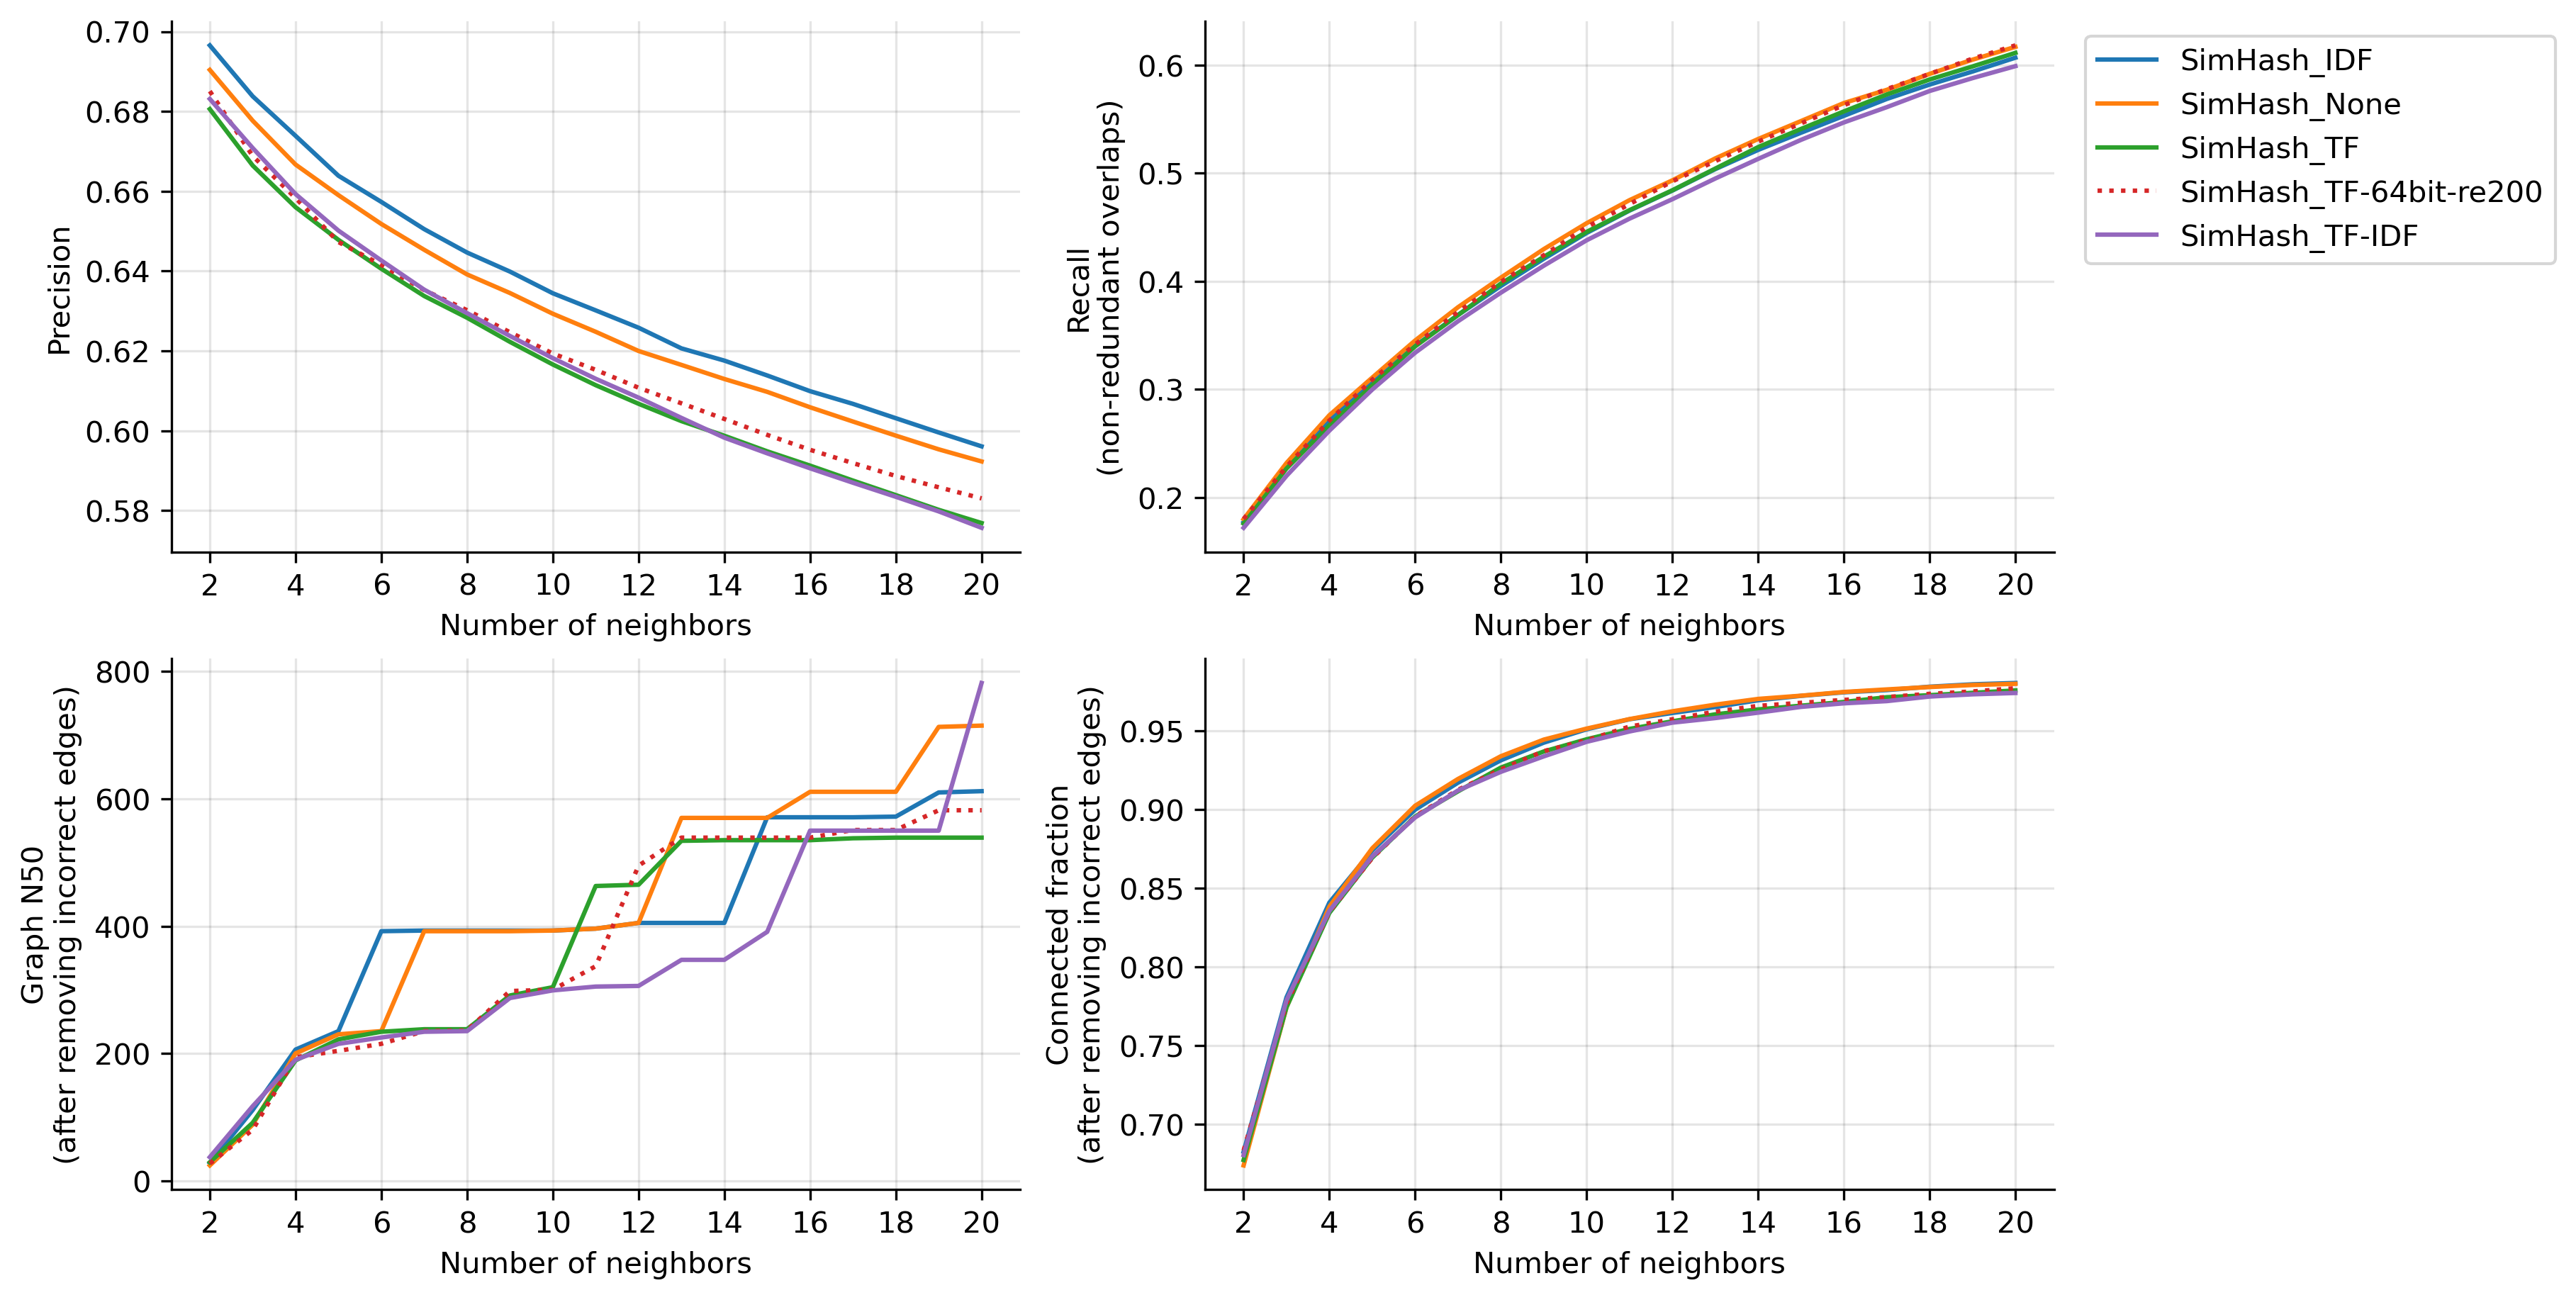

In [42]:
all_stat_df = all_stat_df.replace({'SimHash_TF-64bit-re200':'SimHash_TF-64bit'})  
k_values = np.arange(2, 21)
y_labels = dict(
    precision="Precision",
    nr_recall="Recall\n(non-redundant overlaps)",
    N50="Graph N50\n(after removing incorrect edges)",
    connected_fraction="Connected fraction\n(after removing incorrect edges)"
)

if len(visul_method) <= 10:
    color_list = seaborn.color_palette("tab10")
elif len(visul_method) <= 20:
    color_list = seaborn.color_palette("tab20")
else:
    color_list = seaborn.color_palette("rainbow")

fig, axes = plt.subplots(2, 2, figsize=(12, 6), constrained_layout=True)
for i, ax in enumerate( itertools.chain(*axes) ):
    y = list(y_labels)[i]
    x = 'n_neighbors'
    hue = 'description'
    for j,(desc, group) in enumerate(df.groupby(hue)): 
        if '--' in desc:  
            linestyle = 'solid'  
        elif '64' in desc: 
            linestyle = 'dotted'
        elif '--' in desc:
            linestyle = 'dashdot'
        else:
            linestyle = 'solid'
        ax.plot(group[x], group[y], label=desc, color =  color_list[j], linestyle = linestyle)
    ax.set_xticks([ x for x in k_values if x%2==0]) 
    ax.set_xlabel("Number of neighbors")  
    ax.set_ylabel(y_labels[y])  
    ax.grid(axis='both', color='k', alpha=0.1)  
    
    if i == 1:
        ax.legend(loc="upper left", bbox_to_anchor=(1.02, 1))

    ax.spines[['top', 'right']].set_visible(False)

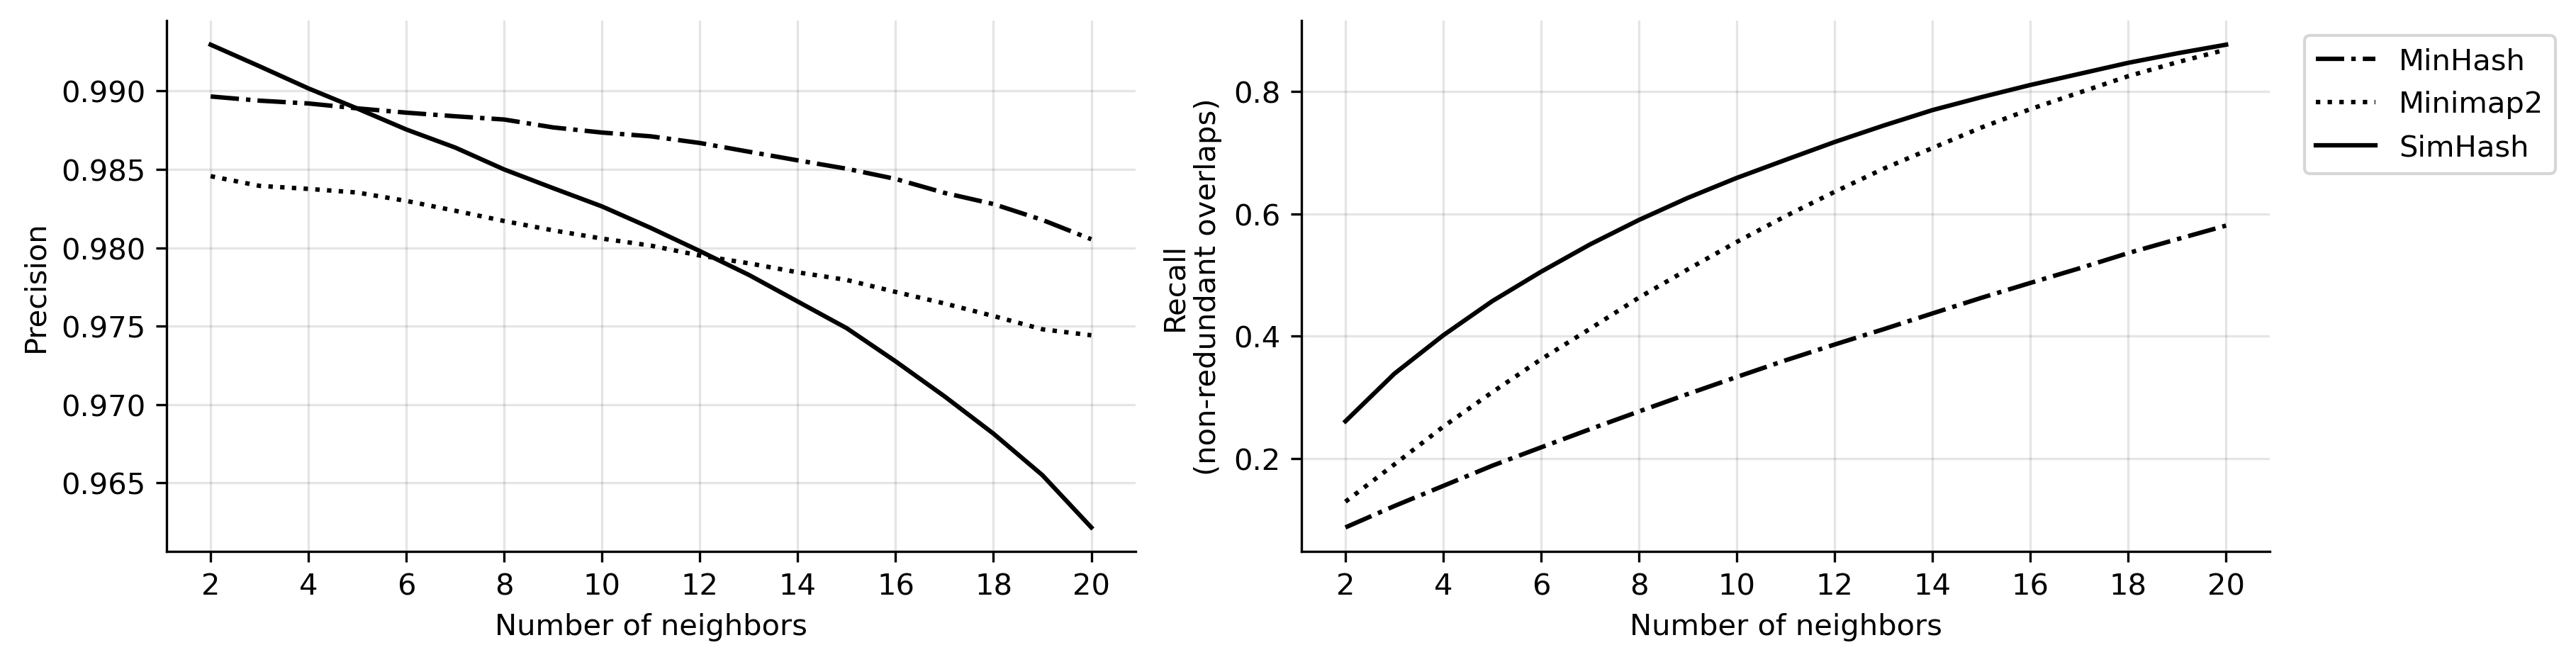

In [28]:
##仅两组
df =df_IGH
df = df.replace({'SimHash_None':'SimHash'})  

k_values = np.arange(2, 21)
y_labels = dict(
    precision="Precision",
    nr_recall="Recall\n(non-redundant overlaps)",
)

if len(visul_method) <= 10:
    color_list = seaborn.color_palette("tab10")
elif len(visul_method) <= 20:
    color_list = seaborn.color_palette("tab20")
else:
    color_list = seaborn.color_palette("rainbow")

fig, axes = plt.subplots(1,2, figsize=(12,3), constrained_layout=True)
for i, ax in enumerate(axes):
    y = list(y_labels)[i]
    x = 'n_neighbors'
    hue = 'description'
    for j,(desc, group) in enumerate(df.groupby(hue)): 
        if 'Sim' in desc:  
            linestyle = 'solid'  
        elif 'Minimap2' in desc: 
            linestyle = 'dotted'
        elif 'MinHash' in desc:
            linestyle = 'dashdot'
        else:
            linestyle = 'dashed'
        ax.plot(group[x], group[y], label=desc, color = 'black', linestyle = linestyle)
    ax.set_xticks([ x for x in k_values if x%2==0]) 
    ax.set_xlabel("Number of neighbors")  
    ax.set_ylabel(y_labels[y])  
    ax.grid(axis='both', color='k', alpha=0.1)  
    
    if i == 1:
        ax.legend(loc="upper left", bbox_to_anchor=(1.02, 1))

    ax.spines[['top', 'right']].set_visible(False)

plt.savefig('IGH_plot.pdf', format='pdf')  


[<Axes: > <Axes: >]


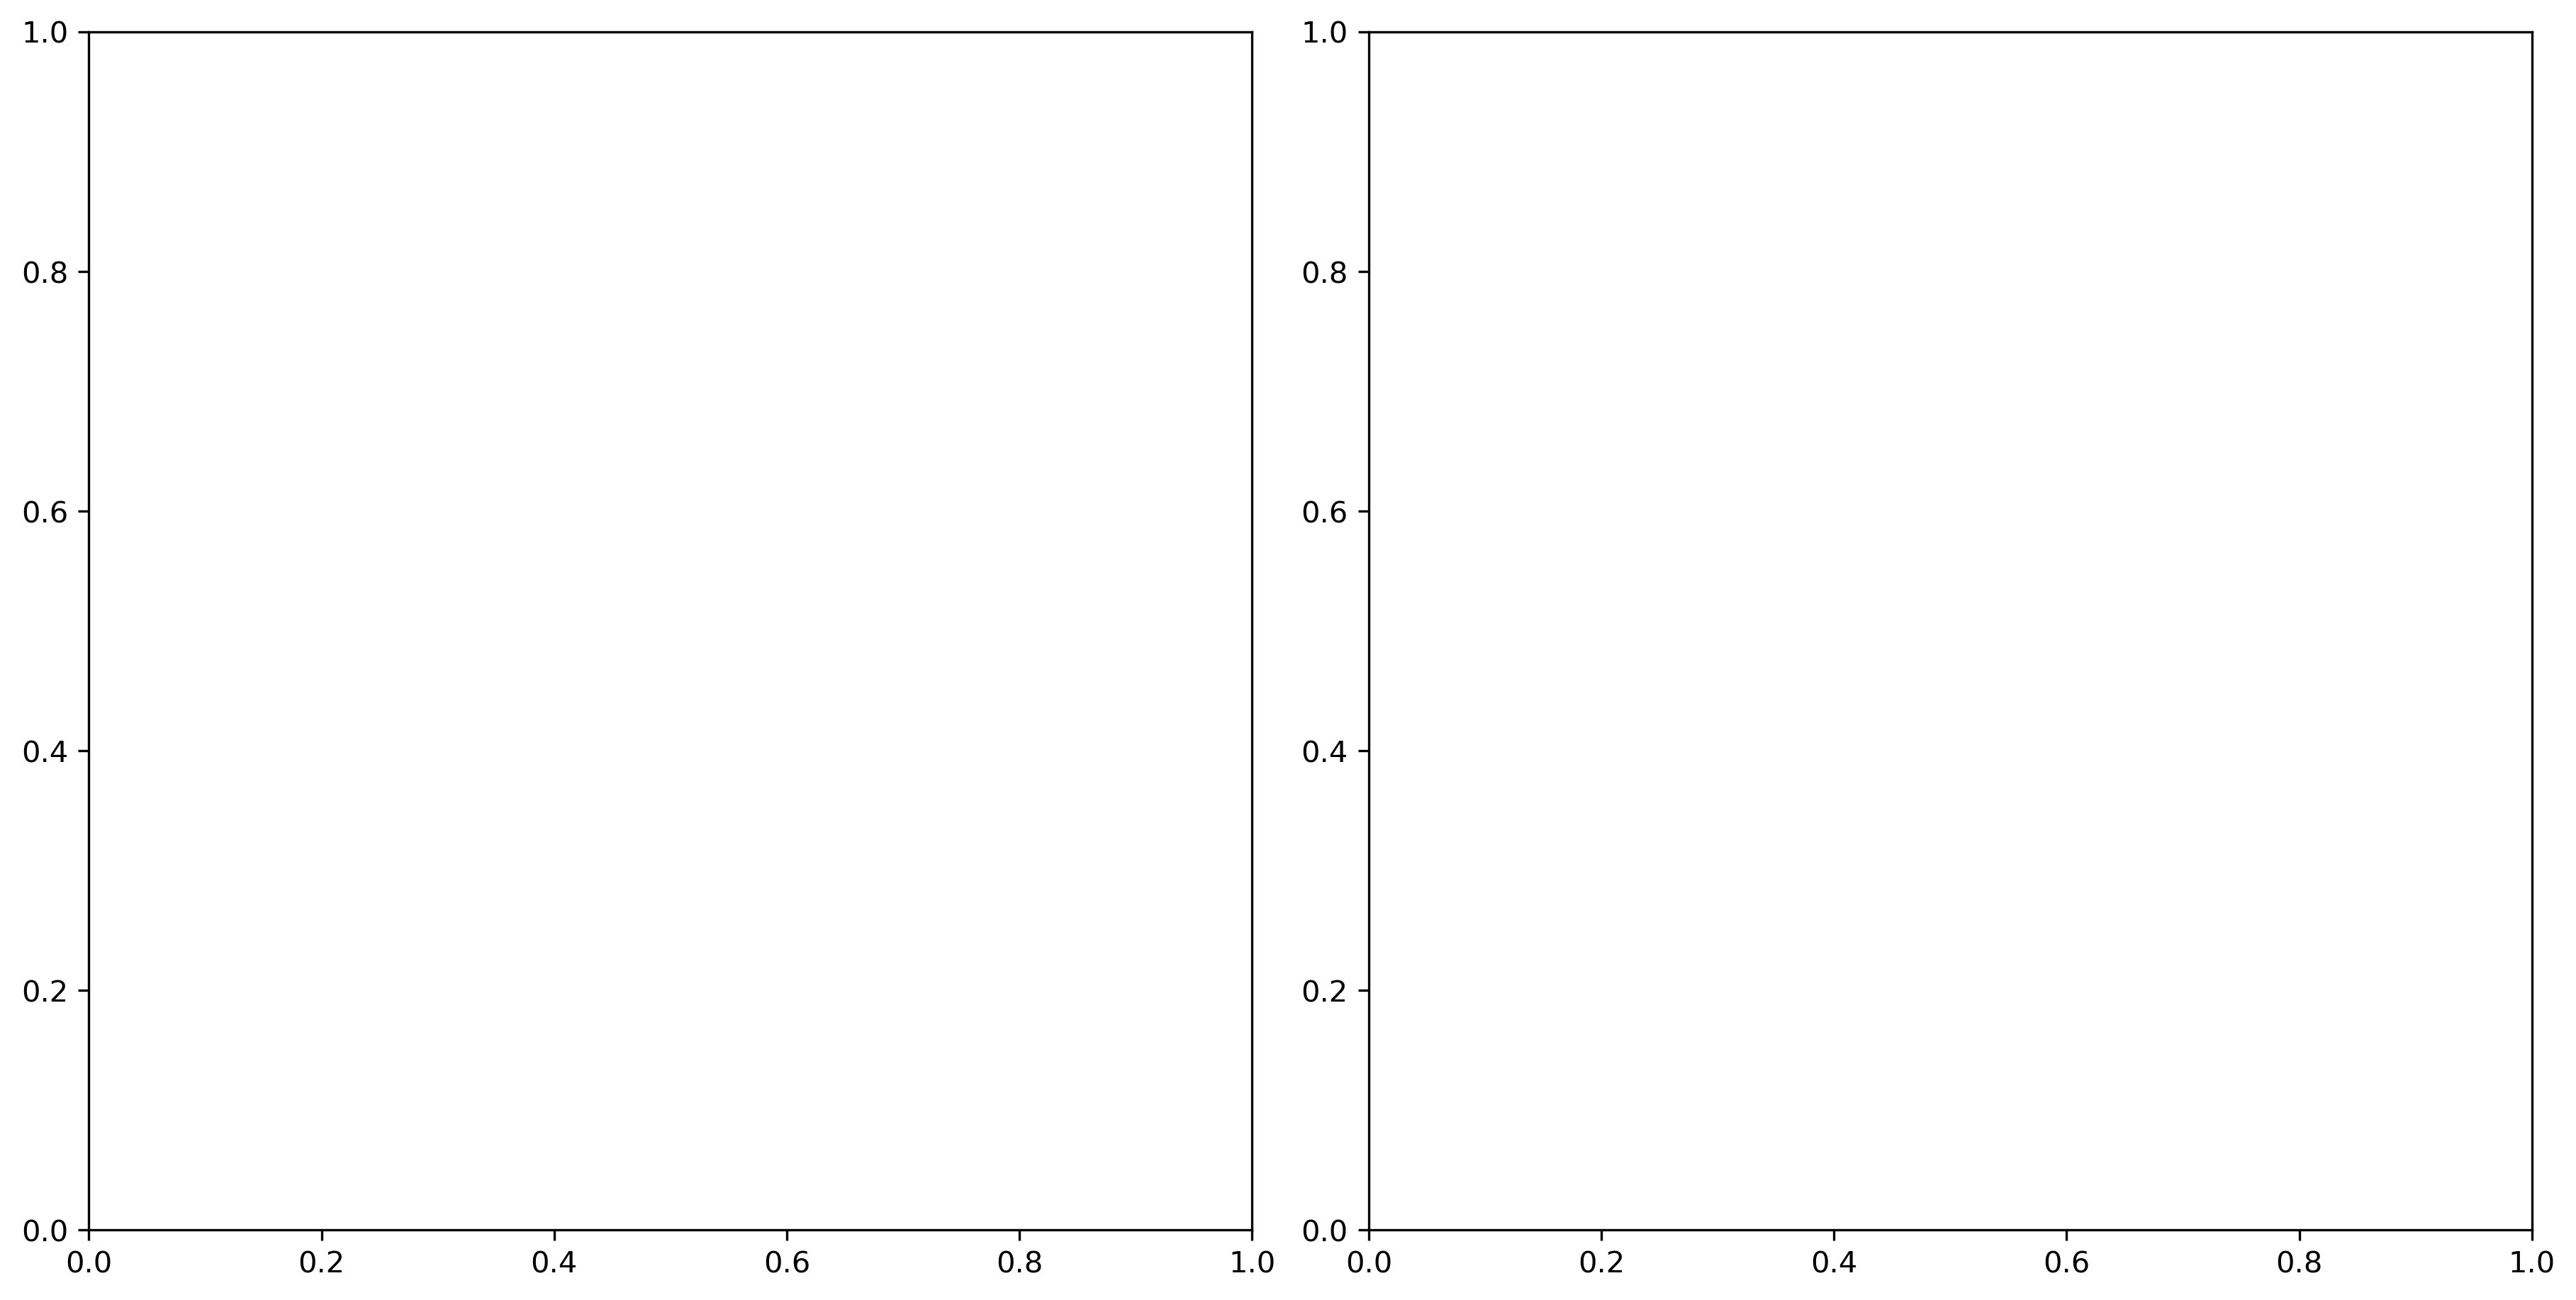

In [12]:
fig, axes = plt.subplots(1,2, figsize=(12, 6), constrained_layout=True)
print(axes)

In [ ]:
##放大precision 局部
k_values = np.arange(2, 21)
y_labels = dict(
    precision="Precision",
    nr_recall="Recall (non-redundant overlaps)",
    N50="Graph N50 (after removing incorrect edges)",
    connected_fraction="Connected fraction (after removing incorrect edges)"
)

color_list = seaborn.color_palette("bwr",9)


fig, ax = plt.subplots(figsize=(8, 8), constrained_layout=True) 
y = list(y_labels)[0]
x = 'n_neighbors'
hue = 'repeat_time'
for j,(desc, group) in enumerate(df.groupby(hue)): 
    ax.plot(group[x], group[y], label=desc, color = color_list[j])

ax.set_xticks(k_values)
ax.set_xlabel("Number of neighbors")  
ax.set_ylabel(y_labels[y])  
ax.set_xlim(4,10)
ax.set_ylim(0.685,0.8)
ax.grid(axis='both', color='k', alpha=0.1)  
ax.legend(loc="upper left", bbox_to_anchor=(1.02, 1))

In [ ]:
k_values
new_k =[ x for x in k_values if x%2==0]

In [ ]:
k_values = np.arange(2, 21)
y_labels = dict(
    precision="Precision",
    nr_recall="Recall (non-redundant overlaps)",
    N50="Graph N50 (after removing incorrect edges)",
    connected_fraction="Connected fraction (after removing incorrect edges)"
)

color_list = seaborn.color_palette("bwr",9)


fig, axes = plt.subplots(2, 2, figsize=(16, 10), constrained_layout=True)
for i, ax in enumerate( itertools.chain(*axes) ):
    y = list(y_labels)[i]
    x = 'n_neighbors'
    hue = 'repeat_time'
    for j,(desc, group) in enumerate(df.groupby(hue)): 

        ax.plot(group[x], group[y], label=desc, color = color_list[j])
    ax.set_xticks(k_values) 
    ax.set_xlabel("Number of neighbors")  
    ax.set_ylabel(y_labels[y])  
    ax.grid(axis='both', color='k', alpha=0.1)  
    
    if i == 1:
        ax.legend(loc="upper left", bbox_to_anchor=(1.02, 1))

    ax.spines[['top', 'right']].set_visible(False)

In [ ]:
import glob
evaluate_dir = '/home/miaocj/docker_dir/kNN-overlap-finder/data/evaluation/Ecoli/all/ONT/kmer_k16/'
file_list = glob.glob(evaluate_dir + '*_overlap_stat.tsv')  
  
# 循环打开文件  
statistic_dfs =[]
for file in file_list:  
    df = pd.read_csv(file, sep='\t') 
    statistic_dfs.append(df)

all_stat_df = pd.concat(statistic_dfs,ignore_index = True)
all_stat_df = all_stat_df.iloc[:,2:]
all_stat_df['connected_fraction'] = 1 - all_stat_df['singleton_fraction']
##筛选用于绘图的method
methods = all_stat_df['description'].unique()
visul_method = []
for method in methods:
    if  'TF-IDF' in method or 'Blend' in method or 'Mini' in method:
        visul_method.append(method)

method_compare = all_stat_df[all_stat_df['description'].isin(visul_method)] 
df2 = method_compare

visul_method

In [ ]:
time_df = df2[df2['n_neighbors']==20]
time_df.to_csv('/home/miaocj/docker_dir/kNN-overlap-finder/time_df.csv',sep='\t')

In [ ]:
time_df

In [ ]:
k_values = np.arange(2, 21)
y_labels = dict(
    precision="Precision",
    nr_recall="Recall (non-redundant overlaps)",
    N50="Graph N50 (after removing incorrect edges)",
    connected_fraction="Connected fraction (after removing incorrect edges)"
)

if len(visul_method) <= 10:
    color_list = seaborn.color_palette("tab10")
elif len(visul_method) <= 20:
    color_list = seaborn.color_palette("tab20")
else:
    color_list = seaborn.color_palette("rainbow")

fig, axes = plt.subplots(2, 2, figsize=(16, 10), constrained_layout=True)
for i, ax in enumerate( itertools.chain(*axes) ):
    y = list(y_labels)[i]
    x = 'n_neighbors'
    hue = 'description'
    for j,(desc, group) in enumerate(df2.groupby(hue)): 
        if 'HNSW' in desc:  
            linestyle = 'dashed'  
        elif 'Hash' in desc: 
            linestyle = 'dotted'
        else:
            linestyle = 'solid'
        ax.plot(group[x], group[y], label=desc, color = color_list[j],linestyle = linestyle)
    ax.set_xticks(k_values) 
    ax.set_xlabel("Number of neighbors")  
    ax.set_ylabel(y_labels[y])  
    ax.grid(axis='both', color='k', alpha=0.1)  
    
    if i == 1:
        ax.legend(loc="upper left", bbox_to_anchor=(1.02, 1))

    ax.spines[['top', 'right']].set_visible(False)

In [ ]:
k_values = np.arange(2, 21)
y_labels = dict(
    precision="Precision",
    nr_recall="Recall (non-redundant overlaps)",
    N50="Graph N50 (after removing incorrect edges)",
    connected_fraction="Connected fraction (after removing incorrect edges)"
)

if len(visul_method) <= 10:
    color_list = seaborn.color_palette("tab10")
elif len(visul_method) <= 20:
    color_list = seaborn.color_palette("tab20")
else:
    color_list = seaborn.color_palette("rainbow")

fig, axes = plt.subplots(2, 2, figsize=(16, 10), constrained_layout=True)
for i, ax in enumerate( itertools.chain(*axes) ):
    y = list(y_labels)[i]
    x = 'n_neighbors'
    hue = 'description'
    for j,(desc, group) in enumerate(df.groupby(hue)): 
        if 'Pro' in desc:  
            linestyle = 'dashed'  
        elif 'Jaccard' in desc: 
            linestyle = 'dotted'
        else:
            linestyle = 'solid'
        ax.plot(group[x], group[y], label=desc, color = color_list[j],linestyle = linestyle)
    ax.set_xticks(k_values) 
    ax.set_xlabel("Number of neighbors")  
    ax.set_ylabel(y_labels[y])  
    ax.grid(axis='both', color='k', alpha=0.1)  
    
    if i == 1:
        ax.legend(loc="upper left", bbox_to_anchor=(1.02, 1))

    ax.spines[['top', 'right']].set_visible(False)

## 绘制plot_graph

In [ ]:
def remove_small_components(graph, min_component_size=10):
    small_components = set()
    for component in nx.connected_components(graph):
        if len(component) < min_component_size:
            small_components |= component
    graph.remove_nodes_from(small_components)
            
    
def plot_graphs(graphs, reference_graph, metadata, *, min_component_size=10, 
                processes=8, layout_method='stdp', figsize=(6, 6), node_size=3,title,
    seed: int = 4829, verbose=True):
    axes = []
    figures = []

    new_graphs = []
    for g in graphs:
        fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 6), constrained_layout=True)
        figures.append(fig)
        ax1.set_title("All edges")
        ax2.set_title("Correct edges")
        
        g = g.copy()
        remove_small_components(g, min_component_size=min_component_size)
        new_graphs.append(g)
        axes.append(ax1)

        g = g.copy()
        remove_false_edges(g, reference_graph)
        remove_small_components(g, min_component_size=min_component_size)
        new_graphs.append(g)
        axes.append(ax2)
        fig.suptitle(title, ha="center", va="bottom", wrap=True, size=7)

    query_graphs = new_graphs
    def plot(i, pos):
        plot_read_graph(
            ax=axes[i],
            query_graph=query_graphs[i],
            reference_graph=reference_graph,
            metadata=metadata,
            pos=pos,
            node_size=node_size,
        )

    with sharedmem.MapReduce(np=processes) as pool:

        def work(i):
            if layout_method == "umap":
                pos = get_umap_layout(graph=query_graphs[i])
            else:
                pos = get_graphviz_layout(
                    graph=query_graphs[i],
                    figsize=figsize,
                    seed=seed,
                    layout_method=layout_method,
                )
            return i, pos

        def reduce(i, pos):
            if verbose:
                print(i, end=" ")
            plot(i, pos)

        pool.map(work, range(len(query_graphs)), reduce=reduce)
        if verbose:
            print("")

    return figures

In [ ]:
MAX_SAMPLE_SIZE = int(1e9)
COVERAGE_DEPTH = 20
max_bucket_size = COVERAGE_DEPTH * 1.5

tsv_path = "/home/miaochangjiu/kNN-overlap-finder/data/feature_matrix/CHM13/HLA/pbsim_ONT_93_30k/kmer_k16/metadata.tsv.gz"
meta_df = pd.read_table(tsv_path).iloc[:MAX_SAMPLE_SIZE, :].reset_index()

def get_read_intervals(meta_df):
    read_intervals = {
        i: [GenomicInterval(strand, start, end)]
        for i, strand, start, end in zip(
            meta_df.index,
            meta_df["reference_strand"],
            meta_df["reference_start"],
            meta_df["reference_end"],
        )
    }
    return read_intervals

read_intervals = get_read_intervals(meta_df)
len(read_intervals)

reference_graph = OverlapGraph.from_intervals(read_intervals)
nr_edges = set((node_1, node_2) for node_1, node_2, data in reference_graph.edges(data=True) if not data['redundant'])
connected_component_count = len(list(nx.connected_components(reference_graph)))
len(reference_graph.nodes), len(reference_graph.edges), len(nr_edges), connected_component_count

In [ ]:
max_n_neighbors = 20
json_path = "/home/miaochangjiu/kNN-overlap-finder/data/feature_matrix/CHM13/HLA/pbsim_ONT_93_30k/kmer_k16/read_features.json.gz"
with gzip.open(json_path, "rt") as f:
    read_features = json.load(f)
    read_features = {i: read_features[i] for i in meta_df.index}
    
read_ids = np.array(list(read_features))
graphs = collections.defaultdict(dict)
k_values = np.arange(2, max_n_neighbors + 1)
datas = np.load('/home/miaochangjiu/kNN-overlap-finder/data/evaluation/CHM13/HLA/pbsim_ONT_93_30k/kmer_k16/WeightedMinHash_Jaccard_None_TF_nbr_matrix.npz',allow_pickle=True)
nbr_indices = datas['arr_0'].item()[0]
for k in k_values:
    graph = OverlapGraph.from_neighbor_indices(
        neighbor_indices=nbr_indices,
        n_neighbors=k,
        read_ids=read_ids,
        require_mutual_neighbors=False,
    )
    graphs[0][k] = graph

In [ ]:
nbr_indices.item()[0]

In [ ]:
%%time
k6_graphs = [graphs[0][6] for i in range(len(graphs))]
plot_graphs(
    k6_graphs, reference_graph=reference_graph, metadata=meta_df, layout_method="sfdp", processes=8,title= 'WeightedMinHash_Jaccard_None_TF'
)